# Essay Keystrokes Project

This project is based on the Kaggle competition [Linking Writing Processes to Writing Quality](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality). The goal of the project is to use the data about each student's writing process while writing an SAT argumentative essay to predict the score that they receive on the essay. The goal of the project is to reduce the RMSE as much as possible. On Kaggle, the top entries have an RMSE of about .56 while median entries have an RMSE of about .58. For the competition, the test data set contains only 5 records; the full test data set is hosted on Kaggle. Because I want to work on GitHub and use this as an opportunity to develop my skills, I only use the training data and base my model performance on a train test split of the training data.

## 1. Importing the Data and Initial Review

### 1a. Imports and Shape

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('Data/train_logs.csv')

In [3]:
train_df.shape

(8405898, 11)

In [4]:
train_scores_df = pd.read_csv('Data/train_scores.csv')

In [5]:
train_scores_df.shape

(2471, 2)

While the train logs have over 8 million records, the train scores have only about 2.5k records. That means that there are around 3k train log records for each train score record. A major part of this project is going to consist of figuring out how to leverage as much value as possible from the high volume of train logs even though they will need to be aggregated to fit with the train score data.

### 1b. Train Log Data

In [6]:
train_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


Looking at the head of the dataframe shows the information that is available for each essay. In general, the data includes the time and position of every mouse click and key stroke. For each of these actions, the data includes the cursor position and word count. Knowing that this data needs to be aggregated to use it with the scores, some categories could include the total action time, the number of events, the final word count, and the time spent on each activity type.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   event_id         int64 
 2   down_time        int64 
 3   up_time          int64 
 4   action_time      int64 
 5   activity         object
 6   down_event       object
 7   up_event         object
 8   text_change      object
 9   cursor_position  int64 
 10  word_count       int64 
dtypes: int64(6), object(5)
memory usage: 705.5+ MB


There are so many logs that the null values are not displaying. To limit the number of records, I create a dataframe that only has the logs for the first essay.

In [8]:
first_df = train_df[train_df['id'] == '001519c8']

In [9]:
first_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2557 entries, 0 to 2556
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2557 non-null   object
 1   event_id         2557 non-null   int64 
 2   down_time        2557 non-null   int64 
 3   up_time          2557 non-null   int64 
 4   action_time      2557 non-null   int64 
 5   activity         2557 non-null   object
 6   down_event       2557 non-null   object
 7   up_event         2557 non-null   object
 8   text_change      2557 non-null   object
 9   cursor_position  2557 non-null   int64 
 10  word_count       2557 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 239.7+ KB


The first essay has a mix of objects and integers. Fortunately, there are no null values. Lastly, I take a look at the total action time, final word count, and time spent on each activity for the first essay to finish my initial review of the data.

In [10]:
first_df['action_time'].sum()

297243

In [11]:
first_df.loc[first_df['event_id']==first_df['event_id'].max(), 'word_count']

2556    255
Name: word_count, dtype: int64

In [12]:
first_df['activity'].value_counts()

Input                                 2010
Remove/Cut                             417
Nonproduction                          120
Replace                                  7
Move From [460, 461] To [465, 466]       1
Move From [284, 292] To [282, 290]       1
Move From [287, 289] To [285, 287]       1
Name: activity, dtype: int64

The first essay has a total action time of 297243 milliseconds. It may be useful to convert that into seconds after aggregating to make the data more interpretable. The final word count is 255 words. The value count for the activity showed that that category is going to need some cleaning-- each time text gets moved, there is a unique label based on the position of the move. That will need to get addressed prior to aggregating the data.

Now that I have a sense of the logs, I take an initial look at the scores.

### 1c. Train Score Data

In [13]:
train_scores_df.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [14]:
train_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2471 non-null   object 
 1   score   2471 non-null   float64
dtypes: float64(1), object(1)
memory usage: 38.7+ KB


In [15]:
score_vals = train_scores_df['score'].value_counts()

In [16]:
score_counts = pd.DataFrame({'Score': score_vals.index, 'Number of Essays': score_vals.values})

In [17]:
score_counts

,Score,Number of Essays
0,4.0,501
1,3.5,486
2,4.5,402
3,3.0,336
4,2.5,201
5,5.0,179
6,5.5,128
7,2.0,92
8,1.5,69
9,6.0,37


In [18]:
score_counts.sort_values(by='Score',inplace=True)

In [19]:
score_counts.reset_index(inplace=True,drop=True)

In [20]:
score_counts

,Score,Number of Essays
0,0.5,5
1,1.0,35
2,1.5,69
3,2.0,92
4,2.5,201
5,3.0,336
6,3.5,486
7,4.0,501
8,4.5,402
9,5.0,179


In [43]:
custom_palette = ['#1768AC' if 3 <= score <= 4.5 else '#A2A7A5' for score in score_counts['Score']]

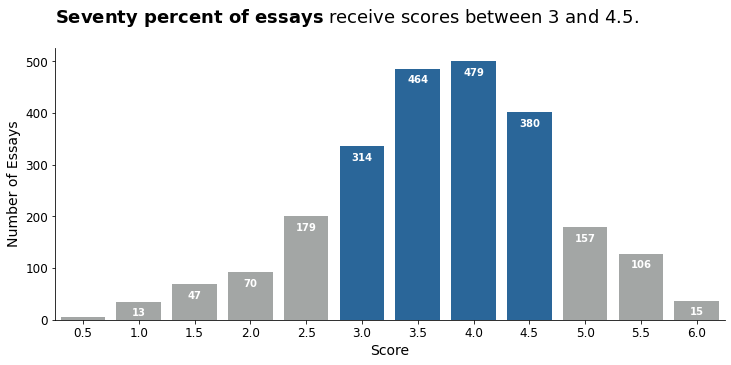

In [44]:
plt.figure(figsize=(12,5))
ax = sns.barplot(x='Score',y='Number of Essays',palette=custom_palette,data=score_counts)
title_text = r"$\bf{" 'Seventy \ percent \ of \ essays' "}$" + " receive scores between 3 and 4.5."

for p in ax.patches:
    height = (p.get_height() - 22)
    width = p.get_width()
    ax.annotate(f'{height:.0f}', (p.get_x() + width/2, height), ha='center', va='center', color='white', weight='bold')
    
plt.title(title_text, loc='left', pad=25, fontsize= 18)
plt.xlabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Number of Essays', fontsize=14)
plt.yticks(fontsize=12)
sns.despine()
plt.show();